In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [ ]:

# ----------------------------------------------------------------------
def in_colab():

    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB

# -------------------------------------------------------------------------
def download_dataset(URL, dataset_name):

    import tensorflow as tf
    import os

    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path


In [ ]:
dataset_dir="/root/.keras/datasets/kvasir-dataset"

In [ ]:
# si on est sur colab
if in_colab():
    # si le dataset n'exist pas
    if not os.path.isdir("/root/.keras/datasets/kvasir-dataset"):
        URL = f"https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"
        dataset_dir = download_dataset(URL, "kvasir-dataset")

elif in_kaggle():
    dataset_dir = "../input/kvasir-dataset/kvasir-dataset"

else:
    dataset_dir = "./kvasir-dataset"

print(f"les dataset est dispo: {dataset_dir}")

1236208343/1236208343 [==============================] - 142s 0us/step
les dataset est dispo: /root/.keras/datasets/kvasir-dataset


In [ ]:
import os
import shutil

# Define paths
kvasir_dataset_path = "/root/.keras/datasets/kvasir-dataset"
no_category_path = "/content/drive/MyDrive/no-category"

# Ensure the target directory exists
target_directory = os.path.join(kvasir_dataset_path, "no-category")
os.makedirs(target_directory, exist_ok=True)

# Copy files from no-category to kvasir-dataset/no-category
for filename in os.listdir(no_category_path):
    source_filepath = os.path.join(no_category_path, filename)
    target_filepath = os.path.join(target_directory, filename)
    shutil.copy(source_filepath, target_filepath)

print("Files copied successfully.")


Files copied successfully.


In [ ]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  9


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,no-category,500
4,normal-cecum,500
5,normal-pylorus,500
6,normal-z-line,500
7,polyps,500
8,ulcerative-colitis,500


In [ ]:
def create_dataset(datadir, categories, img_wid, img_high):

    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))

                # Check if img_array is None
                if img_array is None:
                    print(f"Error loading image: {os.path.join(path, img)}")
                    continue

                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                # Check if ima_resize_rgb is None
                if ima_resize_rgb is None:
                    print(f"Error resizing image: {os.path.join(path, img)}")
                    continue

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)} - {str(e)}")

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_high, 3)
    return X, y

img_wid, img_high = 224, 224
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(y)


X: (4500, 224, 224, 3)
y: (4500,)
[0 0 0 ... 8 8 8]


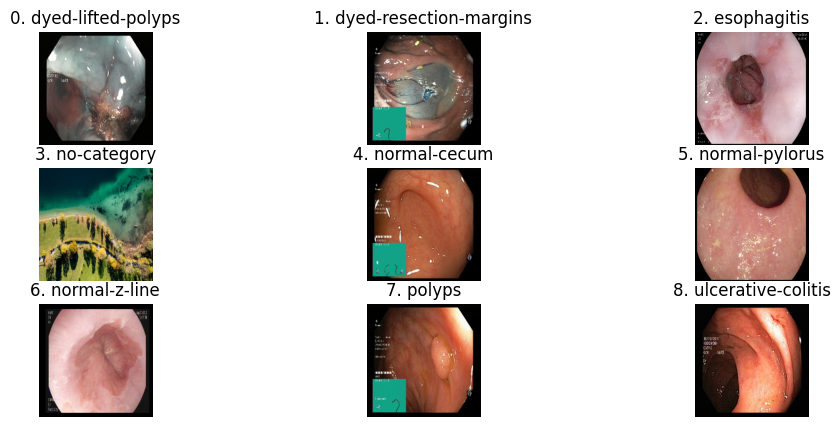

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(9):
    plt.subplot(3, 3,i+1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

In [ ]:
# Converting y to scaler format
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3600, 224, 224, 3)
t_train: (3600, 1)
X_test: (900, 224, 224, 3)
y_test: (900, 1)


In [ ]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2520, 224, 224, 3),  y_train:(2520, 1)
x_train:(1080, 224, 224, 3),  y_train:(1080, 1)
x_train:(900, 224, 224, 3),  y_train:(900, 1)


In [ ]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2520, 224, 224, 3),  y_train:(2520, 9)
x_train:(1080, 224, 224, 3),  y_train:(1080, 9)
x_train:(900, 224, 224, 3),  y_train:(900, 9)


In [ ]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
#LOAD the EfficientNetB3 Model
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        classes=y_train.shape[1],
    )


24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

do_fine_tuning = True
if do_fine_tuning:
    # Fine-tune only a subset of the base model, experiment with the number of trainable layers
    for layer in base_model.layers[-20:]:
        layer.trainable = True
else:
    base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),  # Experiment with dropout rate
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                        

In [ ]:
#model.add(Dense(1024, activation=("relu"), input_dim=512))
#model.add(Dense(512, activation=("relu")))
#model.add(Dense(256, activation=("relu")))
#model.add(Dropout(0.3))
#model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
#model.add(Dense(y_train.shape[1], activation=("softmax")))

In [54]:
#initialize batch_size
batch_size = 32

# initialize number of epochs
epochs = 50

# Learning Rate
learn_rate = 0.001

# initialize stochastique gradient Decent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model compile
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)



In [ ]:
# Freeze the base model
base_model.trainable = False

# Build the model with the frozen base model
model_classifier_alone = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

# Compile the model
model_classifier_alone.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history_classifier_alone = model_classifier_alone.fit(
    x_train,
    y_train,
    epochs=epochs,  # Set the number of epochs for this step
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
78/78 [==============================] - 48s 384ms/step - loss: 1.5304 - accuracy: 0.5268 - val_loss: 0.8282 - val_accuracy: 0.7944
Epoch 2/50
78/78 [==============================] - 19s 241ms/step - loss: 0.6736 - accuracy: 0.7646 - val_loss: 0.5144 - val_accuracy: 0.8491
Epoch 3/50
78/78 [==============================] - 18s 236ms/step - loss: 0.5830 - accuracy: 0.7912 - val_loss: 0.4090 - val_accuracy: 0.8500
Epoch 4/50
78/78 [==============================] - 18s 228ms/step - loss: 0.5045 - accuracy: 0.8096 - val_loss: 0.3682 - val_accuracy: 0.8657
Epoch 5/50
78/78 [==============================] - 18s 230ms/step - loss: 0.4746 - accuracy: 0.8296 - val_loss: 0.3501 - val_accuracy: 0.8694
Epoch 6/50
78/78 [==============================] - 17s 222ms/step - loss: 0.4465 - accuracy: 0.8351 - val_loss: 0.3425 - val_accuracy: 0.8611
Epoch 7/50
78/78 [==============================] - 17s 219ms/step - loss: 0.4326 - accuracy: 0.8386 - val_loss: 0.3025 - val_accuracy: 0.8806

In [ ]:
# Unfreeze all layers in the base model
base_model.trainable = True

# Build the combined model with the trained classifier's layers
model_combined = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    model_classifier_alone.layers[-1]  # Add the trained classifier's output layer
])
sgd_legacy = tf.keras.optimizers.SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)


# Compile the combined model
model_combined.compile(optimizer=sgd_legacy, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the combined model
history_combined = model_combined.fit(
    x_train,
    y_train,
    epochs=epochs,  # Set the number of epochs for this step
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
78/78 [==============================] - 59s 421ms/step - loss: 0.7080 - accuracy: 0.7466 - val_loss: 0.7650 - val_accuracy: 0.8444
Epoch 2/50
78/78 [==============================] - 30s 383ms/step - loss: 0.3517 - accuracy: 0.8723 - val_loss: 0.4560 - val_accuracy: 0.8880
Epoch 3/50
78/78 [==============================] - 31s 402ms/step - loss: 0.2778 - accuracy: 0.8931 - val_loss: 0.3294 - val_accuracy: 0.8981
Epoch 4/50
78/78 [==============================] - 29s 379ms/step - loss: 0.2379 - accuracy: 0.9095 - val_loss: 0.3025 - val_accuracy: 0.8870
Epoch 5/50
78/78 [==============================] - 28s 359ms/step - loss: 0.1824 - accuracy: 0.9311 - val_loss: 0.2761 - val_accuracy: 0.9009
Epoch 6/50
78/78 [==============================] - 30s 389ms/step - loss: 0.1619 - accuracy: 0.9381 - val_loss: 0.2937 - val_accuracy: 0.8880
Epoch 7/50
78/78 [==============================] - 30s 389ms/step - loss: 0.1606 - accuracy: 0.9389 - val_loss: 0.2938 - val_accuracy: 0.8981

In [ ]:
score = model_combined.evaluate(x_test, y_test, verbose=0)
print (score)

[0.25348708033561707, 0.902222216129303]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Test accuracy:", round(score[1], 3))


Test accuracy: 0.902


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np
from prettytable import PrettyTable

# Assuming you have predictions and true labels
predictions = model_combined.predict(x_test)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

category_names = [
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis',
    'no-category',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]

# Initialize lists to store metric scores for each category
roc_auc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i, category_name in enumerate(category_names):
    # Calculate ROC AUC for each class
    roc_auc = roc_auc_score(y_true == i, predictions[:, i])
    roc_auc_scores.append(roc_auc)

    # Convert probabilities to class predictions
    y_pred_class = np.argmax(predictions, axis=1)

    # Calculate F1 score for each class
    f1 = f1_score(y_true, y_pred_class, labels=[i], average='micro')
    f1_scores.append(f1)

    # Calculate Precision for each class
    precision = precision_score(y_true == i, y_pred_class == i)
    precision_scores.append(precision)

    # Calculate Recall for each class
    recall = recall_score(y_true == i, y_pred_class == i)
    recall_scores.append(recall)

# Create a PrettyTable for displaying results (Category-specific table)
table_category = PrettyTable()
table_category.field_names = ["Category", "ROC AUC", "F1 Score", "Precision", "Recall"]

# Add data to the table
for i, category_name in enumerate(category_names):
    table_category.add_row([category_name, f"{roc_auc_scores[i]:.4f}", f"{f1_scores[i]:.4f}", f"{precision_scores[i]:.4f}", f"{recall_scores[i]:.4f}"])

# Print the category-specific table
print("Category-specific Metrics:")
print(table_category)

# Create a PrettyTable for training and validation accuracy and loss
table_accuracy_loss = PrettyTable()
table_accuracy_loss.field_names = ["Metric", "Value"]

# Add data to the table
table_accuracy_loss.add_row(["Training Accuracy", f"{train_accuracy:.4f}"])
table_accuracy_loss.add_row(["Training Loss", f"{train_loss:.4f}"])
table_accuracy_loss.add_row(["Validation Accuracy", f"{val_accuracy:.4f}"])
table_accuracy_loss.add_row(["Validation Loss", f"{val_loss:.4f}"])

# Print the accuracy and loss table
print("\nTraining and Validation Metrics:")
print(table_accuracy_loss)


29/29 [==============================] - 2s 56ms/step
Category-specific Metrics:
+------------------------+---------+----------+-----------+--------+
|        Category        | ROC AUC | F1 Score | Precision | Recall |
+------------------------+---------+----------+-----------+--------+
|   dyed-lifted-polyps   |  0.9932 |  0.8651  |   0.8857  | 0.8455 |
| dyed-resection-margins |  0.9943 |  0.8632  |   0.8542  | 0.8723 |
|      esophagitis       |  0.9863 |  0.8111  |   0.8000  | 0.8224 |
|      no-category       |  1.0000 |  1.0000  |   1.0000  | 1.0000 |
|      normal-cecum      |  0.9995 |  0.9592  |   0.9400  | 0.9792 |
|     normal-pylorus     |  0.9998 |  0.9815  |   0.9725  | 0.9907 |
|     normal-z-line      |  0.9849 |  0.7746  |   0.7701  | 0.7791 |
|         polyps         |  0.9978 |  0.9278  |   0.9278  | 0.9278 |
|   ulcerative-colitis   |  0.9978 |  0.9302  |   0.9615  | 0.9009 |
+------------------------+---------+----------+-----------+--------+

Training and Validati

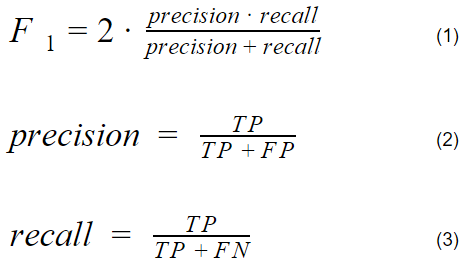

In [ ]:
from IPython.display import Image, display

# Specify the path to your image file
image_path = '/content/sample_data/Screenshot_1.png'

# Display the image
display(Image(filename=image_path))


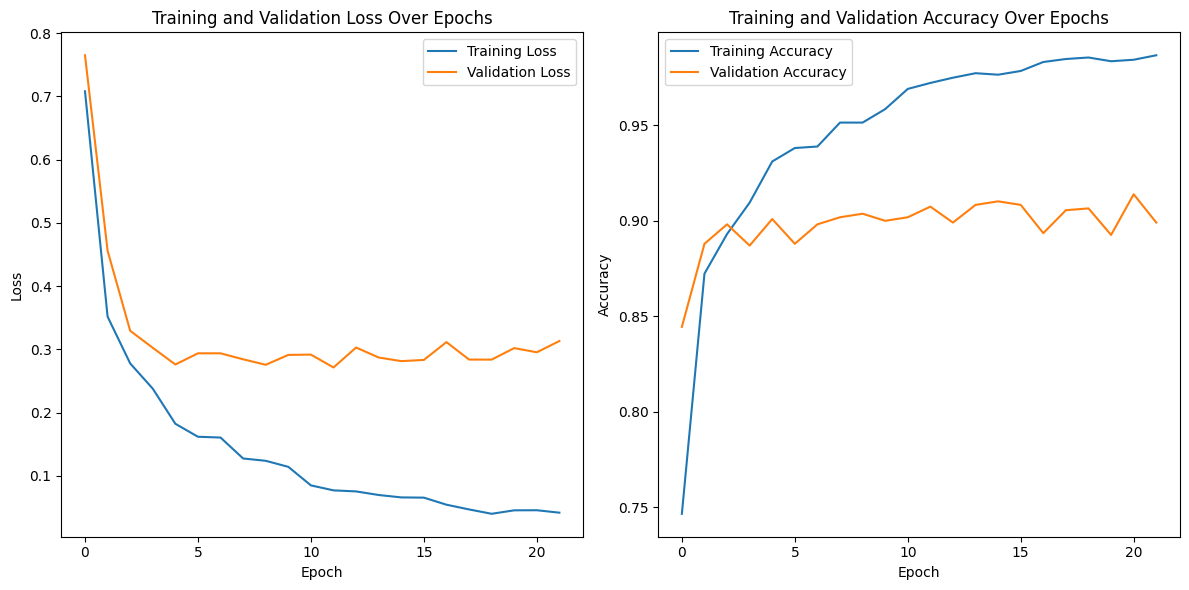

In [ ]:
# Learning curves for loss, training accuracy, and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Training Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def cm_plt(ax, cm, classes, cmap, title, normalize):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax

    # Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

In [ ]:
# Making the predictions
y_pred = np.argmax(model_combined.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

29/29 [==============================] - 1s 44ms/step


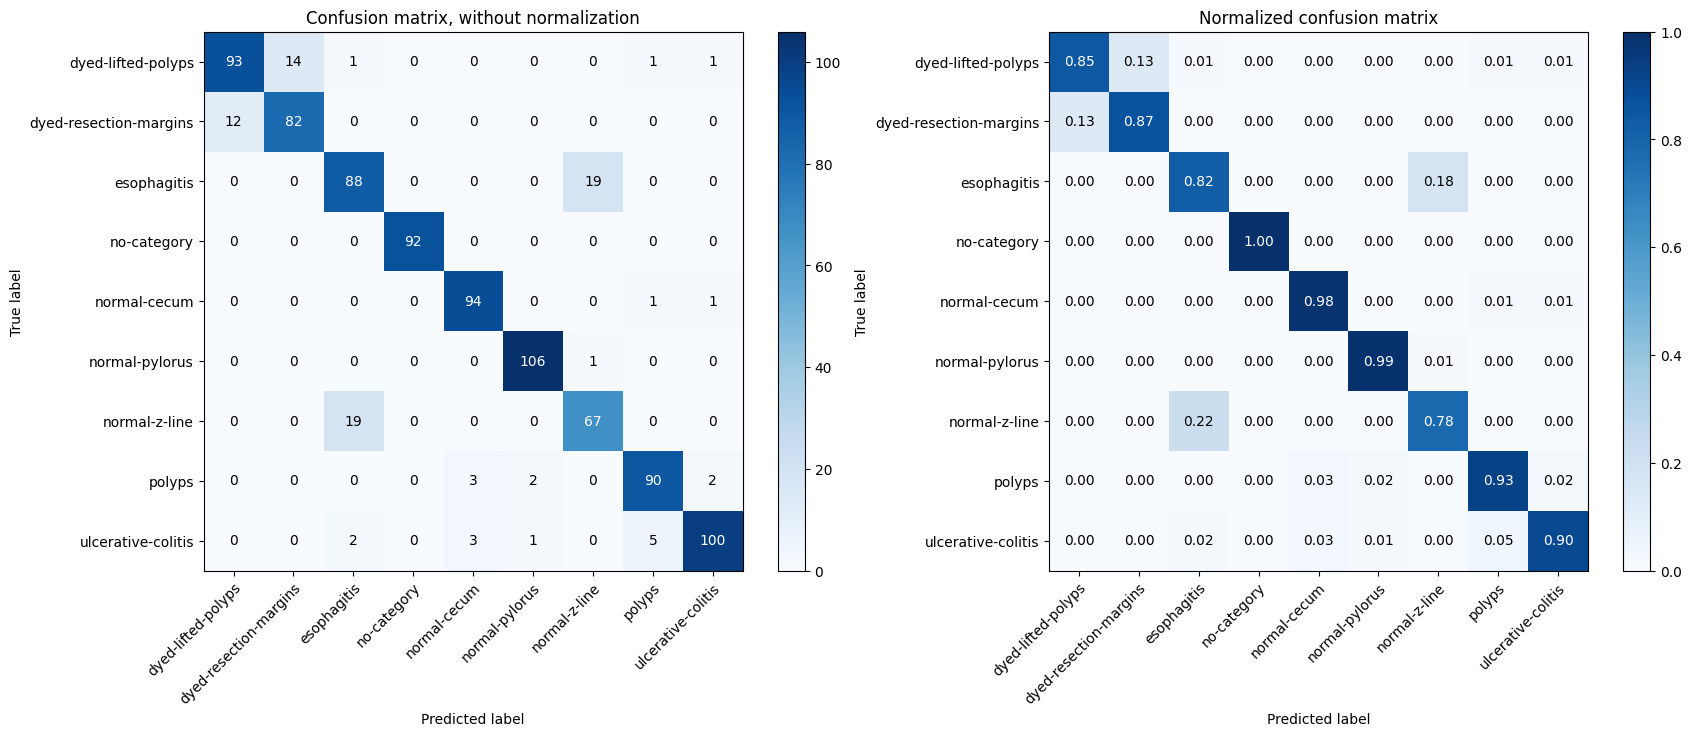

In [ ]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

1/1 [==============================] - 0s 39ms/step


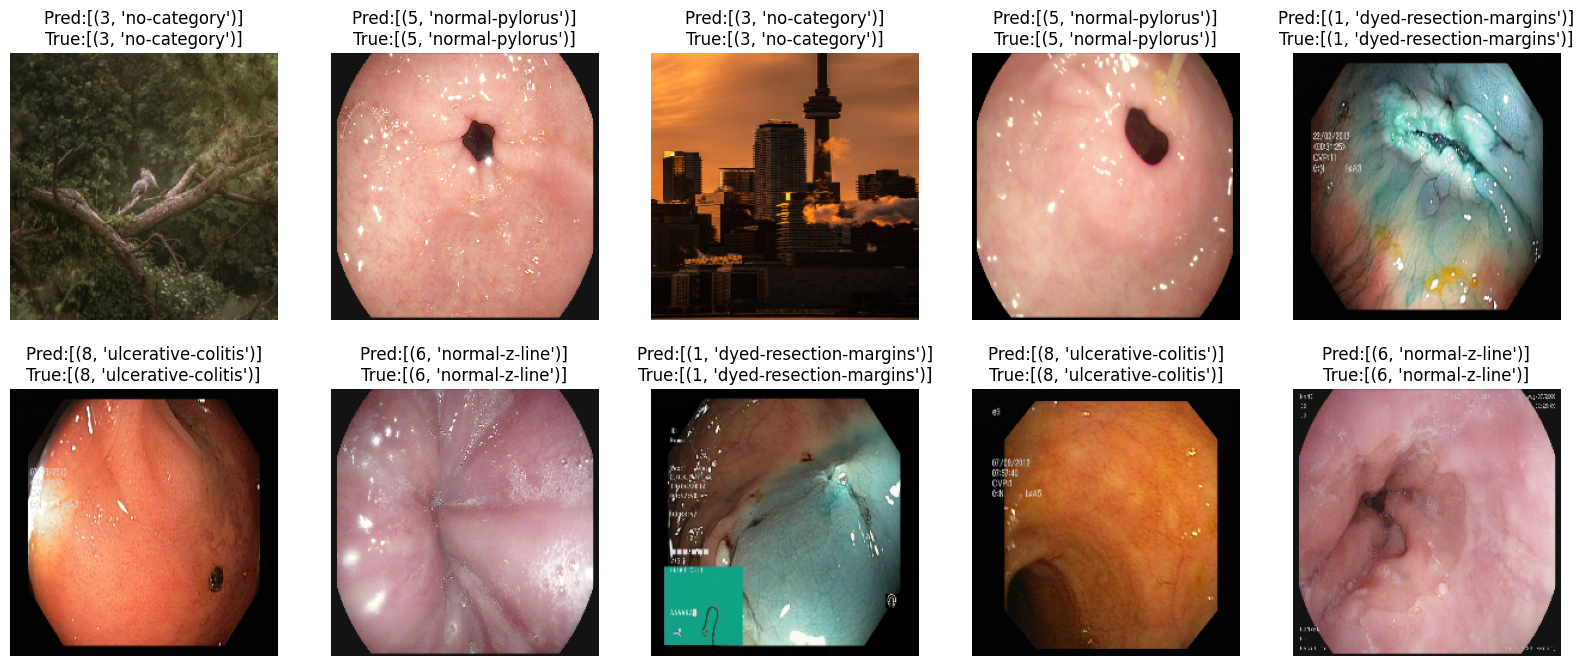

In [ ]:
def predict_categorie_img(img, model, categories):

    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model_combined.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()


In [ ]:
model_combined.save("endoscopy-classification-freezing-90%.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Specify the path in Google Drive where you want to save the model
model_save_path = '/content/drive/My Drive/endoscopy-classification-freezing-90%.h5'

# Save the model
model_combined.save(model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
